In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_dir = "/content/gdrive/My Drive/MachineLearning/PlantIll/"
base_dir = root_dir + 'DPModel'

In [4]:
!pip install -q torch==1.0.0 torchvision

     |████████████████████████████████| 591.8MB 30kB/s 
ERROR: torchvision 0.4.1+cu100 has requirement torch==1.3.0, but you'll have torch 1.0.0 which is incompatible.


In [0]:
from fastai import *
from fastai.vision import *
from fastai.widgets import *

In [0]:
%reload_ext autoreload 
%autoreload 2
%matplotlib inline 

In [0]:
#change directory to where we have our project
import os 
os.getcwd() 
os.chdir('/content/gdrive/My Drive/MachineLearning/PlantIll') 

# Getting the data

In [0]:
## our datapath
path = Path('/content/gdrive/My Drive/Datasets/PlantVillage')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [9]:
path.ls()

[PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/val'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/train'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/models'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/tmp.pth'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/test.jpg')]

In [0]:
##### Data **augmentation** 
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src  = ImageList.from_folder(path)

In [12]:
src.items[0]

PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/test.jpg')

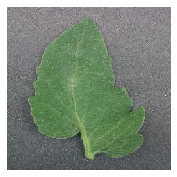

In [13]:
src[110].show()

In [14]:
sd = (src.split_by_folder(train='train', valid='val'))
sd

ItemLists;

Train: ImageList (26022 items)
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /content/gdrive/My Drive/Datasets/PlantVillage;

Valid: ImageList (6464 items)
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /content/gdrive/My Drive/Datasets/PlantVillage;

Test: None

In [15]:
labellists =(sd.label_from_folder())
labellists

LabelLists;

Train: LabelList (26022 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Potato___Late_blight,Potato___Late_blight,Potato___Late_blight,Potato___Late_blight,Potato___Late_blight
Path: /content/gdrive/My Drive/Datasets/PlantVillage;

Valid: LabelList (6464 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Apple___Cedar_apple_rust,Apple___Cedar_apple_rust,Apple___Cedar_apple_rust,Apple___Cedar_apple_rust,Apple___Cedar_apple_rust
Path: /content/gdrive/My Drive/Datasets/PlantVillage;

Test: None

In [0]:
##batch size 
bs= 128
## we will use it in progrissive resizing at the beggining it was 256//2
img_size = 256//2

In [0]:
labellists = (labellists.transform(tfms , size=img_size))

In [0]:
## our data bunch, it contains ou data loaders 
data =  labellists.databunch(bs=bs).normalize(imagenet_stats)

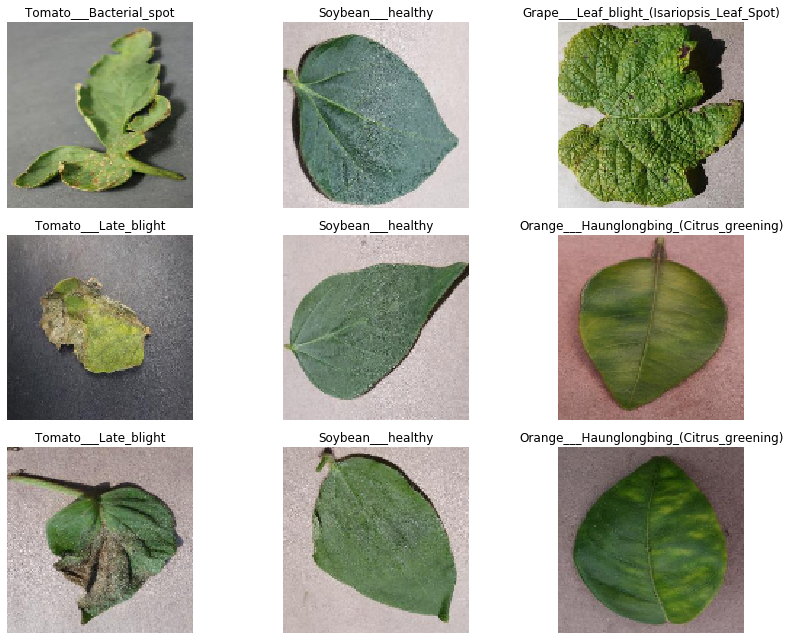

In [19]:
data.show_batch(rows=3, figsize=(12,9))

In [20]:
print(data.classes)
len(data.classes),data.c

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

(39, 39)

# Our Model 

In [21]:
## fbeta is F1 score fbeta,
learn = cnn_learner(data, models.resnet18, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 87163821.74it/s]


beta determines the value of the fbeta applied, eps is there for numeric stability. If sigmoid=True, a sigmoid is applied to the predictions before comparing them to thresh then to the targets. See the https://en.wikipedia.org/wiki/F1_score for details on the fbeta score.

In [22]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
___________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


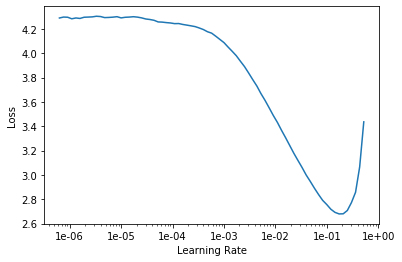

In [23]:
learn.lr_find()
learn.recorder.plot()

# Train the model

In [24]:
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.655961,0.512810,0.864480,1:26:26
1,2.321523,2.180380,0.862624,03:21
2,2.196510,1.315568,0.910272,03:17
3,1.295035,0.622572,0.931467,03:17
4,0.622031,0.321324,0.964728,03:17
5,0.280118,0.124667,0.972618,03:17
6,0.173754,0.092118,0.976330,03:18


In [0]:
learn.save('weight-resnet18-1')

Plotting Losses


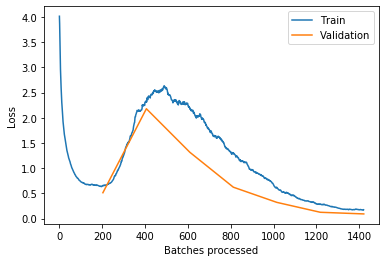

In [26]:
print("Plotting Losses")
learn.recorder.plot_losses()


Plotting metrics


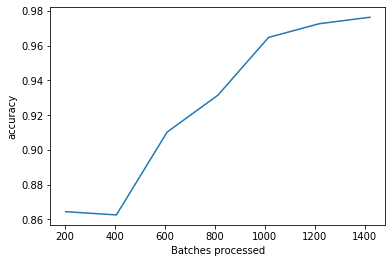

In [27]:
print("Plotting metrics")
learn.recorder.plot_metrics()


Plotting LR


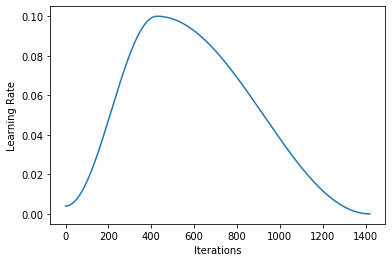

In [28]:
print("Plotting LR")
learn.recorder.plot_lr()

In [0]:
learn.load('weight-resnet18-1');

In [0]:
learn.unfreeze()

In [31]:
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.783927,1.430339,0.779703,03:23
1,1.843503,1.738312,0.790068,03:22
2,1.495373,1.469311,0.812345,03:23
3,1.006238,22.801476,0.898360,03:22
4,0.449425,0.229348,0.955136,03:22
5,0.168280,0.084895,0.975866,03:23
6,0.095870,0.325112,0.980972,03:22


In [0]:
learn.save('weight-resnet18-2')

In [0]:
#before we start the last phase of training we change img_size = 256//2 to img_size = 256
# this change is called progrissive resizing in fastai this method helps
# the model to learn and get a better accuracy 

In [0]:
##batch size 
bs= 128
## we will use it in progrissive resizing at the beggining it was 256//2
img_size = 256

In [0]:
labellists = (labellists.transform(tfms , size=img_size))

In [0]:
## our data bunch, it contains ou data loaders 
data =  labellists.databunch(bs=bs).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=[accuracy])

In [0]:
learn.load('weight-resnet18-2');

In [45]:
learn.freeze_to(-2)
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.315515,1.415289,0.910118,06:02
1,1.806894,26.021248,0.902382,05:59
2,1.477515,94.651588,0.893564,05:59
3,1.151328,1.708404,0.958540,06:00
4,0.514346,7.347978,0.972153,06:01
5,0.221886,0.871678,0.984994,06:00
6,0.123366,0.801144,0.985458,05:59


In [0]:
learn.save('weight-resnet18-3')

In [0]:
learn.load('weight-resnet18-3');

In [48]:
learn.freeze_to(-3)
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.406247,27.624548,0.912748,06:11
1,2.041438,59.137169,0.858756,06:09
2,1.837147,1.587945,0.920637,06:05
3,0.975865,1.031159,0.946627,06:04
4,0.646391,0.280038,0.978032,06:05
5,0.199327,1.196357,0.984220,06:04
6,0.085312,1.895289,0.986696,06:04


In [0]:
learn.save('weight-resnet18-4')

In [0]:
learn.load('weight-resnet18-4');

In [51]:
learn.unfreeze()
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.306911,0.673085,0.943843,06:01
1,2.365205,10.965509,0.761448,06:07
2,1.785399,3.191133,0.923113,06:11
3,1.042381,0.996512,0.969214,06:11
4,0.443779,5.529583,0.976330,06:07
5,0.244649,0.131644,0.988243,06:08
6,0.123513,0.112597,0.989944,06:09


In [0]:
learn.save('weight-resnet18-5')